# Multi-Layer Perceptron and Neural Matrix Factorization

In this notebook, we implement in Pytorch the two Neural Collaborative Filtering models discussed. First, we use the non-linearities in a Multi-Layer Perceptron (MLP) to estimate the user-item interaction. Then, we implement a fusion of matrix factorization and this MLP method. 

We will conduct our different experiments on both these models. We will first test the recommendations with fixed parameters for both models, then we will test our models for different values of K where K is the number of recommended items. Here, the recommended items are topK items in terms of the probability of interaction (given by the final sigmoid function).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from time import time
import numpy as np
import pandas as pd
from load_dataset import Dataset
import math
import heapq
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setting device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Multi-Layer Perceptron Implementation

In [3]:
class MLPModel(nn.Module):
    def __init__(self, num_users, num_items, layers=[64, 32, 16, 8]):
        super(MLPModel, self).__init__()
        
        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, layers[0] // 2)
        self.item_embedding = nn.Embedding(num_items, layers[0] // 2)
        
        # Fully connected layers
        layer_sizes = [layers[0]] + layers
        self.fc_layers = nn.ModuleList()
        
        for i in range(1, len(layer_sizes)):
            self.fc_layers.append(
                nn.Linear(layer_sizes[i-1], layer_sizes[i])
            )
            self.fc_layers.append(nn.ReLU())
        
        # Final prediction layer
        self.prediction = nn.Linear(layers[-1], 1)

    def forward(self, user_input, item_input):
        user_latent = self.user_embedding(user_input)
        item_latent = self.item_embedding(item_input)
        
        # Concatenate both latent vectors of users and items
        vector = torch.cat([user_latent, item_latent], dim=-1)
        
        # Forward propagation
        for layer in self.fc_layers:
            vector = layer(vector)
        
        prediction = self.prediction(vector)
        
        return prediction
    
    def predict(self, user_input, item_input, batch_size=256):
        self.eval()  # Setting model to evaluation
        all_predictions = []

        # Batch prediction
        for i in range(0, len(user_input), batch_size):
            batch_user_input = torch.tensor(user_input[i:i + batch_size], dtype=torch.long).to(device)
            batch_item_input = torch.tensor(item_input[i:i + batch_size], dtype=torch.long).to(device)

            with torch.no_grad(): 
                batch_preds = self.forward(batch_user_input, batch_item_input)
                all_predictions.append(batch_preds)

        return torch.cat(all_predictions, dim=0)

## Neural Matrix Factorization Implementation

In [4]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, mf_dim, layers):
        super(NeuMF, self).__init__()
        
        # MF Embeddings
        self.mf_user_embedding = nn.Embedding(num_users, mf_dim)
        self.mf_item_embedding = nn.Embedding(num_items, mf_dim)
        
        # MLP Embeddings
        self.mlp_user_embedding = nn.Embedding(num_users, layers[0] // 2)
        self.mlp_item_embedding = nn.Embedding(num_items, layers[0] // 2)
        
        # MLP layers
        self.mlp_layers = nn.Sequential()
        for i in range(1, len(layers)):
            self.mlp_layers.add_module(f"linear_{i}", nn.Linear(layers[i-1], layers[i]))
            self.mlp_layers.add_module(f"relu_{i}", nn.ReLU())
        
        # Final prediction layer (applied on the concatenation of MLP and MF outputs)
        predict_size = mf_dim + layers[-1]
        self.final_layer = nn.Linear(predict_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_input, item_input):
        # MF part
        mf_user_latent = self.mf_user_embedding(user_input)
        mf_item_latent = self.mf_item_embedding(item_input)
        mf_vector = mf_user_latent * mf_item_latent  # Element-wise multiplication
        
        # MLP part
        mlp_user_latent = self.mlp_user_embedding(user_input)
        mlp_item_latent = self.mlp_item_embedding(item_input)
        mlp_vector = torch.cat((mlp_user_latent, mlp_item_latent), dim=-1)
        mlp_vector = self.mlp_layers(mlp_vector)
        
        # Concatenate MF and MLP parts
        predict_vector = torch.cat((mf_vector, mlp_vector), dim=-1)
        
        # Final prediction
        prediction = self.final_layer(predict_vector)
        return prediction
    
    def predict(self, user_input, item_input, batch_size=256):
        self.eval()  # Setting model to evaluation
        all_predictions = []

        # Batch prediction
        for i in range(0, len(user_input), batch_size):
            batch_user_input = torch.tensor(user_input[i:i + batch_size], dtype=torch.long).to(device)
            batch_item_input = torch.tensor(item_input[i:i + batch_size], dtype=torch.long).to(device)

            with torch.no_grad(): # Disable retropapagation to save memory
                batch_preds = self.forward(batch_user_input, batch_item_input)
                all_predictions.append(batch_preds)

        return torch.cat(all_predictions, dim=0)

## Testing the models

We will now test the models on the musical instruments dataset. For the evaluation protocol, we opted for a leave-two-out evaluation : for each user we use as a test set his two last interesting items. Moreover, we sample 99 negative items for each user (no interaction between them). After the prediction on these 101 items for each user, we recommend the top K items and evaluate the recommendations with our two test items for each users with the following metrics: Hit-Ratio, NDCG@K, Precision@K, Recall@K. 

### Defining the metrics

In [5]:
def getHR(ranklist, gtItems):
    for item in ranklist:
        if item in gtItems:
            return 1
    return 0

def get_precision(ranklist, gtItems):
    relevant = 0
    for item in ranklist:
        if item in gtItems:
            relevant += 1
    return relevant / len(ranklist)

def getNDCG(ranklist, gtItems):
    dcg = 0.0
    for i, item in enumerate(ranklist):
        if item in gtItems:
            dcg += math.log(2) / math.log(i + 2)  # DCG pour cet item trouvé
    
    # Calcul de l'IDCG (DCG idéal)
    idcg = sum(math.log(2) / math.log(i + 2) for i in range(len(gtItems)))

    return dcg / idcg if idcg > 0 else 0.0

def get_recall(ranklist, gtItems):
    relevant = 0
    for item in ranklist:
        if item in gtItems:
            relevant += 1
    return relevant / len(gtItems)

### Evaluating the model

In [6]:
def evaluate_model(model, testRatings, testNegatives, K):
    """
    Evaluate the performance (HR, NDCG@k, precision@k, recall@k) of top-K recommendation
    Return: score of each test rating.
    """
    global _model
    global _testRatings
    global _testNegatives
    global _K
    _model = model
    _testRatings = testRatings
    _testNegatives = testNegatives
    _K = K
        
    hits, ndcgs, precisions, recalls = [],[], [], []
    for idx in range(len(_testRatings)):
        (hr,ndcg,p,r) = eval_one_user(idx)
        hits.append(hr)
        ndcgs.append(ndcg)   
        precisions.append(p)
        recalls.append(r)   
    return (hits, ndcgs,precisions,recalls)

def eval_one_user(idx):
    rating = _testRatings[idx]
    items = _testNegatives[idx]
    u = rating[0]
    gtItems = rating[1:]
    items += gtItems
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), u, dtype = 'int32')
    predictions = _model.predict(users, np.array(items), batch_size=100)
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i].max()
    items.pop()
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(_K, map_item_score, key=map_item_score.get)
    hr = getHR(ranklist, gtItems)
    ndcg = getNDCG(ranklist, gtItems)
    precision = get_precision(ranklist, gtItems)
    recall = get_recall(ranklist, gtItems)
    return (hr, ndcg, precision, recall)

### Loading the dataset

In [7]:
t1 = time()
dataset = Dataset('data/')
train, testRatings, testNegatives = dataset.trainMatrix, dataset.testRatings, dataset.testNegatives
num_users, num_items = train.shape
print("Load data done [%.1f s]. #user=%d, #item=%d, #train=%d, #test=%d" 
          %(time()-t1, num_users, num_items, train.nnz, len(testRatings)))

Load data done [0.7 s]. #user=5107, #item=1003, #train=32644, #test=5107


In [8]:
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [], [], []
    num_items = train.shape[1]
    for (u, i) in train.keys():
        # Positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)  # Positive instance label = 1
        
        # Negative instances
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            while (u, j) in train:
                j = np.random.randint(num_items)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)  # Negative instance label = 0
    return user_input, item_input, labels

### Evaluating models

In [12]:
# Setting parameters
layers = [64,32,16,8]
mf_dim = 8
num_negatives = 3
learning_rate = 0.001
batch_size = 256
epochs = 20
verbose = 1
topK = 10 # Here, we recommend 10 items

In [10]:
# Fonction d'initialisation des poids
def initialize_weights_normal(model, mean=0.0, std=0.01):
    for module in model.modules():
        if isinstance(module, nn.Linear):  # Appliquer uniquement aux couches linéaires
            nn.init.normal_(module.weight, mean=mean, std=std)
            if module.bias is not None:  # Initialiser les biais à zéro
                nn.init.constant_(module.bias, 0.0)

In [ ]:
# Build model and move it to GPU if available
model = MLPModel(num_users, num_items, layers).to(device)
    
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Check Init performance
t1 = time()
(hits, ndcgs, precisions, recalls) = evaluate_model(model, testRatings, testNegatives, topK)
hr, ndcg, p, r = np.array(hits).mean(), np.array(ndcgs).mean(), np.array(precisions).mean(), np.array(recalls).mean()
print('Init: HR = %.4f, NDCG = %.4f, Precision@k = %.4f, Recall@k = %.4f [%.1f]' %(hr, ndcg, p, r, time()-t1))
    
# Train model
best_hr, best_ndcg, best_p, best_r, best_iter = hr, ndcg, p, r, -1
loss_mlp = []
hr_mlp = []
recall_mlp = []


for epoch in range(100):
    t1 = time()
    # Generate training instances
    user_input, item_input, labels = get_train_instances(train, num_negatives)
        
    # Convert to tensors and move to GPU
    user_input = torch.LongTensor(user_input).to(device)
    item_input = torch.LongTensor(item_input).to(device)

    labels = torch.FloatTensor(labels).to(device)  # Labels should be LongTensor for CrossEntropyLoss
    
    # Training        
    model.train()
    optimizer.zero_grad()
    predictions = model(user_input, item_input)
        
    # Compute loss
    labels = labels.unsqueeze(1)
    loss_fn = nn.BCEWithLogitsLoss()
    loss = loss_fn(predictions, labels)
    loss.backward()
    optimizer.step()

    t2 = time()

    # Evaluation
    if epoch % verbose == 0:  # Utilisation de verbose pour afficher les résultats chaque X epochs
        model.eval()
        (hits, ndcgs, precisions, recalls) = evaluate_model(model, testRatings, testNegatives, topK)
        hr, ndcg, p, r, loss_val = np.array(hits).mean(), np.array(ndcgs).mean(), np.array(precisions).mean(), np.array(recalls).mean(), loss.item()
        print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, Precision@k = %.4f, Recall@k = %.4f, loss = %.4f [%.1f s]' 
                % (epoch,  t2-t1, hr, ndcg, p, r, loss_val, time()-t2))
        loss_mlp.append(loss_val)
        recall_mlp.append(r)
        hr_mlp.append(hr)
        if hr > best_hr:
            best_hr, best_ndcg, best_p, best_r, best_iter = hr, ndcg, p, r, epoch

print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f, Precision@k = %.4f, Recall@k = %.4f. " %(best_iter, best_hr, best_ndcg, best_p, best_r))


Init: HR = 0.1843, NDCG = 0.0547, Precision@k = 0.0196, Recall@k = 0.0978 [17.4]
Iteration 0 [0.1 s]: HR = 0.1974, NDCG = 0.0598, Precision@k = 0.0211, Recall@k = 0.1053, loss = 0.6780 [16.7 s]
Iteration 1 [0.1 s]: HR = 0.1653, NDCG = 0.0468, Precision@k = 0.0173, Recall@k = 0.0864, loss = 0.7732 [16.5 s]
Iteration 2 [0.1 s]: HR = 0.1698, NDCG = 0.0497, Precision@k = 0.0177, Recall@k = 0.0887, loss = 0.6327 [17.0 s]
Iteration 3 [0.1 s]: HR = 0.1492, NDCG = 0.0439, Precision@k = 0.0155, Recall@k = 0.0777, loss = 0.6186 [12.8 s]
Iteration 4 [0.1 s]: HR = 0.0127, NDCG = 0.0057, Precision@k = 0.0013, Recall@k = 0.0064, loss = 0.5991 [9.8 s]
Iteration 5 [0.1 s]: HR = 0.0027, NDCG = 0.0013, Precision@k = 0.0003, Recall@k = 0.0015, loss = 0.5808 [8.8 s]


In [12]:
# Build model and move it to GPU if available
model = NeuMF(num_users, num_items, mf_dim, layers).to(device)
    
# Set optimizer    
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
# Check Init performance
t1 = time()
(hits, ndcgs, precisions, recalls) = evaluate_model(model, testRatings, testNegatives, topK)
hr, ndcg, p, r = np.array(hits).mean(), np.array(ndcgs).mean(), np.array(precisions).mean(), np.array(recalls).mean()
print('Init: HR = %.4f, NDCG = %.4f, Precision@k = %.4f, Recall@k = %.4f [%.1f]' %(hr, ndcg, p, r, time()-t1))
    
# Train model
best_hr, best_ndcg, best_p, best_r, best_iter = hr, ndcg, p, r, -1
loss_neumf = []
hr_neumf = []
recall_neumf = []

for epoch in range(epochs):
    t1 = time()
    # Generate training instances
    user_input, item_input, labels = get_train_instances(train, num_negatives)
        
    # Convert to tensors and move to GPU
    user_input = torch.LongTensor(user_input).to(device)
    item_input = torch.LongTensor(item_input).to(device)

    labels = torch.FloatTensor(labels).to(device)  # Labels should be LongTensor for CrossEntropyLoss
    
    # Training        
    model.train()
    optimizer.zero_grad()
    predictions = model(user_input, item_input)
        
    # Compute loss
    labels = labels.unsqueeze(1)
    loss_fn = nn.BCEWithLogitsLoss()
    loss = loss_fn(predictions, labels)
    loss.backward()
    optimizer.step()

    t2 = time()

    # Evaluation
    if epoch % verbose == 0:  # Utilisation de verbose pour afficher les résultats chaque X epochs
        model.eval()
        (hits, ndcgs, precisions, recalls) = evaluate_model(model, testRatings, testNegatives, topK)
        hr, ndcg, p, r, loss_val = np.array(hits).mean(), np.array(ndcgs).mean(), np.array(precisions).mean(), np.array(recalls).mean(), loss.item()
        print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, Precision@k = %.4f, Recall@k = %.4f, loss = %.4f [%.1f s]' 
                  % (epoch,  t2-t1, hr, ndcg, p, r, loss_val, time()-t2))
        loss_neumf.append(loss_val)
        recall_neumf.append(r)
        hr_neumf.append(hr)
        if hr > best_hr:
            best_hr, best_ndcg, best_p, best_r, best_iter = hr, ndcg, p, r, epoch

print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f, Precision@k = %.4f, Recall@k = %.4f. " %(best_iter, best_hr, best_ndcg, best_p, best_r))

Init: HR = 0.1845, NDCG = 0.0536, Precision@k = 0.0192, Recall@k = 0.0962 [24.2]
Iteration 0 [0.1 s]: HR = 0.2125, NDCG = 0.0647, Precision@k = 0.0225, Recall@k = 0.1126, loss = 0.6704 [19.0 s]
Iteration 1 [0.1 s]: HR = 0.2130, NDCG = 0.0625, Precision@k = 0.0225, Recall@k = 0.1126, loss = 0.8521 [17.4 s]
Iteration 2 [0.1 s]: HR = 0.1995, NDCG = 0.0598, Precision@k = 0.0209, Recall@k = 0.1047, loss = 0.5857 [16.6 s]
Iteration 3 [0.1 s]: HR = 0.1939, NDCG = 0.0579, Precision@k = 0.0205, Recall@k = 0.1027, loss = 0.6235 [16.7 s]
Iteration 4 [0.1 s]: HR = 0.1931, NDCG = 0.0568, Precision@k = 0.0205, Recall@k = 0.1024, loss = 0.6293 [16.5 s]
Iteration 5 [0.1 s]: HR = 0.1817, NDCG = 0.0518, Precision@k = 0.0189, Recall@k = 0.0945, loss = 0.6224 [17.0 s]
Iteration 6 [0.1 s]: HR = 0.1794, NDCG = 0.0517, Precision@k = 0.0186, Recall@k = 0.0932, loss = 0.6115 [16.7 s]
Iteration 7 [0.1 s]: HR = 0.1880, NDCG = 0.0533, Precision@k = 0.0195, Recall@k = 0.0977, loss = 0.6001 [17.2 s]
Iteration 8 [0.

KeyboardInterrupt: 

Let's plot our losses, hit-ratios, and recall@k to compare both models.

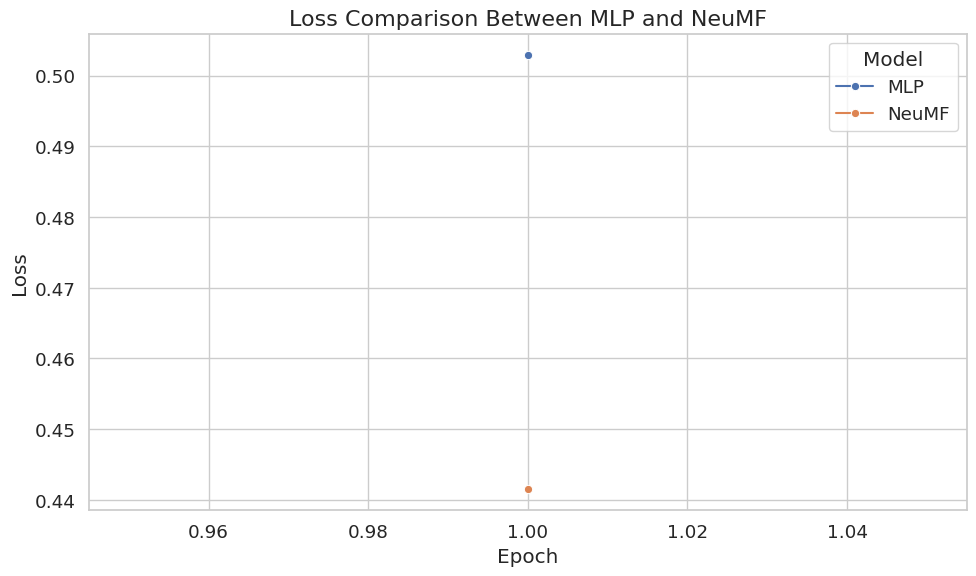

In [13]:
epochs = range(1, len(loss_mlp) + 1)

# Create a DataFrame for Seaborn
data = pd.DataFrame({
    "Epoch": list(epochs) * 2,
    "Loss": loss_mlp + loss_neumf,
    "Model": ["MLP"] * len(loss_mlp) + ["NeuMF"] * len(loss_neumf)
})

# Plot
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x="Epoch", y="Loss", hue="Model", marker="o")

# Add labels and title
plt.title("Loss Comparison Between MLP and NeuMF", fontsize=16)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Model")
plt.tight_layout()
plt.show()